In [149]:
# See https://github.com/CINPLA/pyopenephys
%load_ext autoreload
%autoreload 2
import pyopenephys
from utils.custom_functions import *
import utils.plot_functions as pf
import matplotlib.pylab as plt
import numpy as np
import math
import sys
import os
sys.path.append("../") # go to parent 
from BehaviouralAnalysis.utils.plot_utils import axvlines
import quantities as pq
from scipy.signal import filtfilt, find_peaks
import copy
import matplotlib
%matplotlib inline
import pickle
#import dill
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
# 0. define some parameters
experiments_folder = 'LFP02'
number_of_channels = 64
# load positions from the probe
probeposfile = open('utils/2shankNeuroNexusPositions.pkl', 'rb')
xcoords = pickle.load(probeposfile)
ycoords = pickle.load(probeposfile)
kcoords = pickle.load(probeposfile)
probeposfile.close()

In [151]:
# 1. read data
GeneralDataDir = get_data_folder()
# Create out directory if it does not exist
outputDir = GeneralDataDir + "/" + experiments_folder + '/Analyzed_data/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

# Get the list of experiments in the folder
experiments_list = [f for f in os.listdir(GeneralDataDir + experiments_folder + "/")\
                    if os.path.isdir(GeneralDataDir + experiments_folder + "/" + f)\
                    if 'experiment1' in os.listdir(GeneralDataDir + experiments_folder + "/" + f)]
for i,e in enumerate(experiments_list):
    print(i, ' -- ', e)

0  --  LFP02_2020-12-04_14-32-07_Right_slice1_site1_0.5
1  --  LFP02_2020-12-04_14-33-25_Right_slice1_site1_0.7
2  --  LFP02_2020-12-04_14-41-23_Right_slice1_site2_0.7
3  --  LFP02_2020-12-04_14-46-42_Right_slice1_site3_0.7
4  --  LFP02_2020-12-04_14-49-28_Right_slice1_site3_0.6
5  --  LFP02_2020-12-04_14-51-55_Right_slice1_site3_0.6_preLTD
6  --  LFP02_2020-12-04_15-03-30_Right_slice1_site3_0.6_LTD
7  --  LFP02_2020-12-04_15-14-19_Right_slice1_site3_0.6_postLTD
8  --  LFP02_2020-12-04_16-38-47_Left_slice1_site1_0.6
9  --  LFP02_2020-12-04_16-53-20_R_slice2_site1_0.6
10  --  LFP02_2020-12-04_16-54-49_R_slice2_site1_1.0
11  --  LFP02_2020-12-04_17-05-23_L_slice2_site1_0.6
12  --  LFP02_2020-12-04_17-07-16_L_slice2_site1_1.0


In [152]:
# load experiment
Experiment = experiments_list[7]
print(Experiment)

# Create a dicctionary to save variables for later retrieval
saving_dicc = {}
# add directory to save
saving_dicc['outputDir'] = outputDir
# add experiment to save
saving_dicc['Experiment'] = Experiment

file = pyopenephys.File(GeneralDataDir + experiments_folder + "/" + Experiment)
experiments = file.experiments
experiment1 = experiments[0]
recordings = experiment1.recordings
recording = recordings[0]
analog_signals = recording.analog_signals
signals = analog_signals[0]
events_data = recording.events
events = events_data[0]
print('Duration: ', recording.duration)
print('Sampling Rate: ', recording.sample_rate)

# Check if this experiment has been analized already and if so, load the dicctionary
if os.path.isfile(outputDir + Experiment + '_saved_variables.pkl'):    
    # Load data (deserialize)
    print('\n---> This experiment has been analyzed previously.\nLoading the analyzed data as well...')
    with open(outputDir + Experiment + '_saved_variables.pkl', 'rb') as handle:
        loaded_data = pickle.load(handle)
    
    #TODO: turn the diccionary data into variables so they can be analyzed with the same code below
    

LFP02_2020-12-04_15-14-19_Right_slice1_site3_0.6_postLTD
Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format
.dat:  continuous.dat
Estimated samples:  127589120  Numchan:  72
Duration:  4252.970633333333 1/Hz
Sampling Rate:  30000.0 Hz


In [ ]:
## ANALOG INPUT TO OE
# Alternatively, get the analog channel get the analog channel
analog_pulsepal = signals.signal[64]
# find mid point and get idxs above
#light_on_idx = np.where(analog_pulsepal > (max(analog_pulsepal) - min(analog_pulsepal))/2)[0]
light_on_idx = np.where(analog_pulsepal > (np.median(analog_pulsepal)*10))[0]
# indexes for onset, adding 1 because of np.diff
onset_idxofidx = np.where(np.diff(light_on_idx)>1)[0] + 1
offset_idxofidx = onset_idxofidx - 1
# add the first and last occurrence
onset_idxofidx = np.insert(onset_idxofidx, 0, 0)
offset_idxofidx = np.append(offset_idxofidx, len(light_on_idx)-1)
# get the times
onset_times = signals.times[light_on_idx[onset_idxofidx]]
offset_times = signals.times[light_on_idx[offset_idxofidx]]

# classify the pulses and save them into a diccionary
TTLs = {
        'soundPresentationTimes': onset_times,
        'soundOffsetTimes': offset_times
}
saving_dicc['TTLs'] = TTLs
# get the difference (THIS ASSUMES IS ALWAYS THE SAME) For plotting purposes so far
offset_delay = np.median(TTLs['soundOffsetTimes'] - TTLs['soundPresentationTimes']).item()
saving_dicc['offset_delay'] = offset_delay
# get the light pulse interval. Not used for now
lp_int = np.median(np.diff(TTLs['soundPresentationTimes'])).item()
# to test that works
plt.figure(figsize=(17,3))
plt.plot(signals.times, analog_pulsepal)
axvlines(onset_times, ax = plt.gca())
axvlines(offset_times, ax = plt.gca())
#plt.xlim(17.75,17.76)
#plt.xlim(61.737,61.7385)
print('calculated light pulse length {} seconds'.format(offset_delay))
print('calculated light pulse interval {} seconds'.format(lp_int))

calculated light pulse length 0.000466666667307436 seconds
calculated light pulse interval 10.000866666666752 seconds


Save results for looking at them online in bonsai [optional]

In [ ]:
#np.array(signals.signal).transpose().tofile('/mnt/c/Users/herny/Desktop/to_test_in_bonsai')

In [ ]:
#test = np.array(signals.signal).transpose()
#test[500000:800000,].tofile('/mnt/c/Users/herny/Desktop/to_test_in_bonsai')

#### Filter [optional]

In [ ]:
# FILTERING PARAMETERS
Filter_High_Value = 1500
b, a = butter_lowpass(Filter_High_Value, recording.sample_rate)

In [ ]:
# OPTIONAL CHECKPOINT
# test on one channel
ChID = 19
fd = filtfilt(b, a, signals.signal[ChID])

# Plot some examples of the traces of that channel aligned to the pulses
fig, axs = plt.subplots(3, 1, figsize=(15, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .25, wspace=.1)
axs = axs.ravel()

for i in range(3):
    pulseTime = events.times[i*2*2].item() # *2 because TTLs come in pairs (beginning and end of pulse)
    pulseFrame = int((pulseTime - signals.times[0].item()) * recording.sample_rate.item()) # minus the beginning as it is not always 0
    pFS = int(pulseFrame - 0.01 * recording.sample_rate.item()) # 10ms before and after
    pFF = int(pulseFrame + 0.01 * recording.sample_rate.item())
    #extract frames around the pulse
    axs[i].plot(signals.times[pFS:pFF], signals.signal[ChID][pFS:pFF])
    axs[i].plot(signals.times[pFS:pFF], fd[pFS:pFF])
    axvlines(pulseTime, ax = axs[i])

plt.show()

In [ ]:
# filter the data
filtered_data = copy.deepcopy(signals.signal)
for electrodeID in range(number_of_channels):
    filtered_data[electrodeID] = filtfilt(b, a, signals.signal[electrodeID])
    update_progress(electrodeID / number_of_channels)
update_progress(1)

In [ ]:
# override filtering
#filtered_data = signals.signal

In [ ]:
# align data
# interval for traces alignment. In seconds. Range of alignment
intervalWindow = [-0.02,0.02]
#firstpulses  = getFirstPulses(events.times, .5)
traces_aligned = alignTrace(filtered_data, signals.times, TTLs['soundPresentationTimes'], intervalWindow, recording.sample_rate)
intervalTimes = np.arange(intervalWindow[0], intervalWindow[1], 1/recording.sample_rate.base)
print(Experiment + ' analyzed...')

In [ ]:
# Translate data
# seconds to calculate the mean before 0 and translate each trace
sToSubstract = 0.005
traces_translated = copy.deepcopy(traces_aligned)
for electrodeID in range(len(traces_translated)):
    for traceID in range(len(traces_translated[electrodeID])):        
        traces_translated[electrodeID][traceID] = translateTrace(traces_aligned[electrodeID][traceID], intervalTimes, recording.sample_rate, sToSubstract)   
    update_progress(electrodeID / len(traces_translated))
update_progress(1)

In [ ]:
# Override trace translation
#traces_translated = copy.deepcopy(traces_aligned)

In [ ]:
# Flip the traces
traces_translated = [-x for x in traces_translated]

In [ ]:
# Get the averages of each electrode
Average_traces = [None] * number_of_channels
for j in range(number_of_channels):
    avg = np.mean(traces_translated[j], axis = 0)
    Average_traces[j] = avg
    update_progress(j / number_of_channels)
update_progress(1)

saving_dicc['Average_traces'] = Average_traces

In [ ]:
'''
# Optional Check-point. Plot the signal of each channel
fig, axs = plt.subplots(math.ceil(number_of_channels/4), 4, figsize=(17, 26), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
plt.suptitle(Experiment, y=0.9)

for j in range(number_of_channels):
    for i in range(traces_translated[j].shape[0]):
        axs[j].plot(intervalTimes, traces_translated[j][i,], color = 'grey', linewidth = 0.1, alpha = 0.6)
    axs[j].plot(intervalTimes, Average_traces[j])
    # zoom in the curve
    axs[j].set_xlim(-0.002, 0.008)
    axs[j].text(.5,.9,"Channel Idx "+str(signals.channel_id[j]), horizontalalignment='center', transform=axs[j].transAxes)
    update_progress(j / number_of_channels)

for j in range(number_of_channels):    
    axvlines(0, alpha = 0.3, ax = axs[j])
    axvlines(offset_delay, alpha = 0.3, ax = axs[j])
    axs[j].set_ylim(np.min(Average_traces),np.max(Average_traces))
#plt.savefig(outputDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()
'''

In [ ]:
# select times to plot
from_seconds = -0.002
to_seconds = 0.008
iTvals = (intervalTimes > from_seconds) * (intervalTimes < to_seconds)
idx = np.where(iTvals)
light_idx = np.where((intervalTimes > 0) * (intervalTimes < offset_delay))

saving_dicc['idx'] = idx
saving_dicc['light_idx'] = light_idx

In [ ]:
# Filter the average traces so that the derivative and the parameters are easier to compute
Filter_High_Value = 1500
b, a = butter_lowpass(Filter_High_Value, recording.sample_rate)

filtered_averages = copy.deepcopy(Average_traces)
for electrodeID in range(number_of_channels):
    filtered_averages[electrodeID] = filtfilt(b, a, Average_traces[electrodeID])
    update_progress(electrodeID / number_of_channels)
update_progress(1)

saving_dicc['filtered_averages'] = filtered_averages

### If you want to break the session into chunks to compare in between them (e.g. LTD protocol) go to that section below

In [ ]:
# Compute the derivative and the important parameters, and check that all worked out

ElectrodeLFPData = [filtered_averages[j][idx] for j in range(len(filtered_averages))]
ElectrodeLFPTimes = intervalTimes[idx]

saving_dicc['ElectrodeLFPData'] = ElectrodeLFPData
saving_dicc['ElectrodeLFPTimes'] = ElectrodeLFPTimes

Derivatives = np.diff(ElectrodeLFPData, axis = 1)
DerivativeTimes = ElectrodeLFPTimes[:-1]
    
'''
explore the possibility of measuring the drop of signal: max - min of first bump, as some of the
traces have an ascending component first
'''
MaxChR2LowThr = 0.
MaxChR2List = []
MaxChR2ListIdx = []
MaxChR2ListTime = []
for j in range(len(Derivatives)):
    for i in range(len(Derivatives[j])):
        if np.logical_and(np.logical_and(Derivatives[j][i+1]<=0, Derivatives[j][i] > 0), ElectrodeLFPTimes[i] > MaxChR2LowThr):
            MaxChR2ListTime.append(ElectrodeLFPTimes[i+1])
            MaxChR2List.append(ElectrodeLFPData[j][i+1])
            MaxChR2ListIdx.append(i+1)
            break

saving_dicc['MaxChR2ListTime'] = MaxChR2ListTime
saving_dicc['MaxChRList'] = MaxChR2List
saving_dicc['MaxChR2ListIdx'] = MaxChR2ListIdx
            
# for the minima of the ChR2 bump, find the first ascending 0 cross of the derivative after a specified time
MinChR2LowThr = 0.0002
MinChR2List = []
MinChR2ListIdx = []
MinChR2ListTime = []
for j in range(len(Derivatives)):
    for i in range(len(Derivatives[j])):
        if np.logical_and(np.logical_and(Derivatives[j][i+1]>=0, Derivatives[j][i] < 0), ElectrodeLFPTimes[i] > MinChR2LowThr):
            MinChR2ListTime.append(ElectrodeLFPTimes[i+1])
            MinChR2List.append(ElectrodeLFPData[j][i+1])
            MinChR2ListIdx.append(i+1)
            break

saving_dicc['MinChR2ListTime'] = MinChR2ListTime
saving_dicc['MinChR2List'] = MinChR2List
saving_dicc['MinChR2ListIdx'] = MinChR2ListIdx
            
ChR2Drop = np.array(MaxChR2List) - np.array(MinChR2List)
saving_dicc['ChR2Drop'] = ChR2Drop

# for the maximum slope of the LFP, find the biggest minima after that
DerMin = []
DerMinIdx = []
DerMinTime = []
for j in range(len(Derivatives)):
    peaks, _ = find_peaks(-1 * Derivatives[j])
    peaks = peaks[peaks>MinChR2ListIdx[j]]
    DerMin.append(np.min(Derivatives[j][peaks]))
    DerMinIdx.append(peaks[np.argmin(Derivatives[j][peaks])])
    DerMinTime.append(ElectrodeLFPTimes[DerMinIdx[j]])
    
saving_dicc['DerMin'] = DerMin
saving_dicc['DerMinIdx'] = DerMinIdx
saving_dicc['DerMinTime'] = DerMinTime
    
fig, axs = plt.subplots(math.ceil(len(Derivatives)/5), 5, figsize=(17,20), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
#plt.suptitle('Electrode ID ' + str(ElectrodeID), y=0.9, x=0.5)
for j in range(len(Derivatives)):
    axs[j].plot(ElectrodeLFPTimes[:-1], Derivatives[j])
    axs[j].plot(DerMinTime[j], DerMin[j], "x", color = 'purple')
    #axs[j].plot(MinChR2ListTime[j], MinChR2List[j], "x", color = 'purple')
    axvlines(MinChR2ListTime[j], ax = axs[j])
    axvlines(MaxChR2ListTime[j], ax = axs[j])
    axs[j].axhline(0, color="gray", linestyle = '--')
    #axs[j].set_xlim(0.001, 0.002)
    axs[j].text(.5, .9, j, horizontalalignment='center', transform=axs[j].transAxes)

plt.savefig(outputDir + Experiment + '_Derivatives_Sanity_Check.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# This is like looking at the probe from the front
# identify those indexes that look good in terms of timing
# THIS MIGHT NEED TO GET MORE COMPLEX EVENTUALLY
timing_test = np.array([-MinChR2ListTime[j] + DerMinTime[j] for j in range(len(DerMinTime))]) < 0.003
saving_dicc['timing_test'] = timing_test

# Calculate the normalized slope (the bigger the higher the negative slope)
normalized_slope = -np.array([DerMin[i] / ChR2Drop[i] for i in range(len(DerMin))])
saving_dicc['normalized_slope'] = normalized_slope

# plot the traces with the identified points
fig, axs = plt.subplots(1,1, figsize=(20, 40), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
#axs = axs.ravel()
x_scaler = 10000
y_scaler = 0.09
plt.title('traces of {} miliseconds'.format(1000 * (to_seconds - from_seconds)))
plt.suptitle(Experiment, y=0.893)

# plot the average trace
axs, han1, lab1 = pf.plot_traces_on_probe(ax=axs, intervalTimes=intervalTimes, traces=Average_traces,
                                          idx=idx, xcoords=xcoords, ycoords=ycoords,
                                          x_scaler=x_scaler, y_scaler=y_scaler,
                                          normalized_slope=normalized_slope,
                                          color='k', alpha=.2, linewidth=6,
                                          new_label='average trace', spread=True)   

# plot the filtered trace on top
axs, han2, lab2 = pf.plot_traces_on_probe(ax=axs, intervalTimes=intervalTimes, traces=filtered_averages,
                                          idx=idx, xcoords=xcoords, ycoords=ycoords,
                                          x_scaler=x_scaler, y_scaler=y_scaler,
                                          points_to_plot=[DerMinIdx, MinChR2ListIdx, MaxChR2ListIdx],
                                          normalized_slope=normalized_slope, timing_test=timing_test,
                                          color='k', alpha=1, linewidth=1,
                                          include_electrode_numbers=True, new_label='refiltered avg',
                                          spread=True)

# plot the light
axs, han3, lab3 = pf.plot_traces_on_probe(ax=axs, intervalTimes=intervalTimes, traces=Average_traces,
                                          idx=light_idx, xcoords=xcoords, ycoords=ycoords,
                                          x_scaler=x_scaler, y_scaler=y_scaler,
                                          normalized_slope=normalized_slope,
                                          color='r', alpha=.7, linewidth=3, new_label='light on',
                                          spread=True)
    
#TODO: Add to legend time and uV values    
axs.legend(handles=[han1, han2, han3], labels=[lab1, lab2, lab3], loc='lower right', fontsize='xx-large',
           frameon=False)

plt.savefig(outputDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [112]:
# Option to remove a shank from the analysis
# 4-shank: from left to right, their IDs are 4, 3, 2, 1. Leave it equal to 0 if none is to be removed
# 2-shank: left is 1, right is 2
shank_to_remove = 1
saving_dicc['shank_to_remove'] = shank_to_remove

idx_to_keep = kcoords != shank_to_remove
saving_dicc['idx_to_keep'] = idx_to_keep

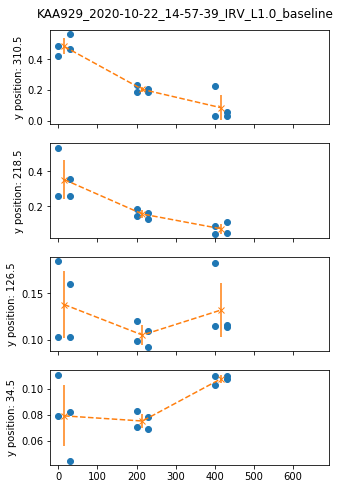

In [113]:
# make groups of four electrodes in y
ygroups = np.split(np.flip(np.sort(np.unique(ycoords))), 4)
# make groups of x positions to calculate means
if shank_to_remove==0:
    xgroups = np.split(np.sort(np.unique(xcoords)), 4)
else:
    xgroups = np.split(np.sort(np.unique(xcoords[idx_to_keep])), 3)

x_mean_pos = np.mean(xgroups, axis=1) # for plotting
# plot
fig, axs = plt.subplots(len(ygroups), 1, figsize=(5, 8), facecolor='w', edgecolor='k', sharex=True, sharey=False)
fig.subplots_adjust(hspace = .2)
axs = axs.ravel()
plt.suptitle(Experiment, y=0.92)
count = 0
for yg in ygroups:
    y_idxs = np.logical_and(np.isin(ycoords, yg), idx_to_keep)
    axs[count].plot(xcoords[y_idxs], normalized_slope[y_idxs], 'o')
    axs[count].set_ylabel('y position: {}'.format(np.mean(yg)))
    # calculate mean and standard deviation and make a quality control out of that
    x_means = []
    x_stds = []
    for xg in xgroups:
        x_idxs = np.isin(xcoords, xg)
        xy_idxs = np.logical_and(x_idxs, y_idxs)
        x_means.append(np.mean(normalized_slope[xy_idxs]))
        x_stds.append(np.std(normalized_slope[xy_idxs]))
    axs[count].errorbar(x_mean_pos, x_means, x_stds,
                        linestyle='--', marker='x')
    
    axs[count].set_xlim(left=-20, right=max(xcoords)*1.1)
    count+=1

plt.savefig(outputDir + Experiment + '_Slope.pdf', transparent=True, bbox_inches='tight')
plt.show()

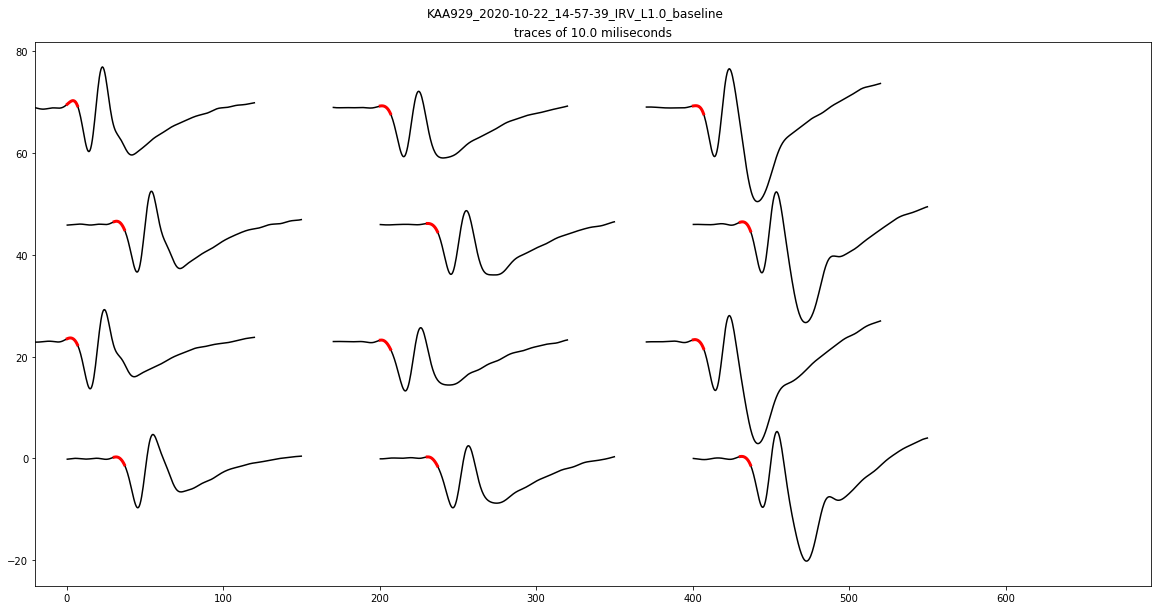

In [114]:
# PLOT THE NORMALIZED SLOPE OF A GOOD EXAMPLE Y POSITION: 0, 1, 2, 3 STARTING FROM THE TOP OF THE PREVIOUS PLOT
selected_y_position = 3

sel_ygroup = np.isin(ycoords, ygroups[selected_y_position])
sel_elec = np.logical_and(sel_ygroup, idx_to_keep)
sel_idx = [i for i, x in enumerate(sel_elec) if x]


# plot the traces with the identified points
fig, axs = plt.subplots(1,1, figsize=(20, 10), facecolor='w', edgecolor='k', sharex=True, sharey='row')
norm_y_scaler = 10
plt.title('traces of {} miliseconds'.format(1000 * (to_seconds - from_seconds)))
plt.suptitle(Experiment, y=0.93)

for i in sel_idx:
    axs.plot(xcoords[i] + intervalTimes[idx] * x_scaler,
             ycoords[i] + filtered_averages[i][idx]/(ChR2Drop[i]) * norm_y_scaler,
             color = 'k')
    # plot when the light is on
    axs.plot(xcoords[i] + intervalTimes[light_idx] * x_scaler,
             ycoords[i] + filtered_averages[i][light_idx]/(ChR2Drop[i]) * norm_y_scaler,
             color = 'r',
             linewidth = 3)
axs.set_xlim(left=-20, right=max(xcoords)*1.1)
#TODO: Add legends    
    
plt.savefig(outputDir + Experiment + '_NormalizedAndSelected.pdf', transparent=True, bbox_inches='tight')

plt.show()

In [25]:
# Save the relevant structures 
# Store data (serialize)
with open(outputDir + Experiment + '_saved_variables.pkl', 'wb') as handle:
    pickle.dump(saving_dicc, handle, protocol=pickle.HIGHEST_PROTOCOL)

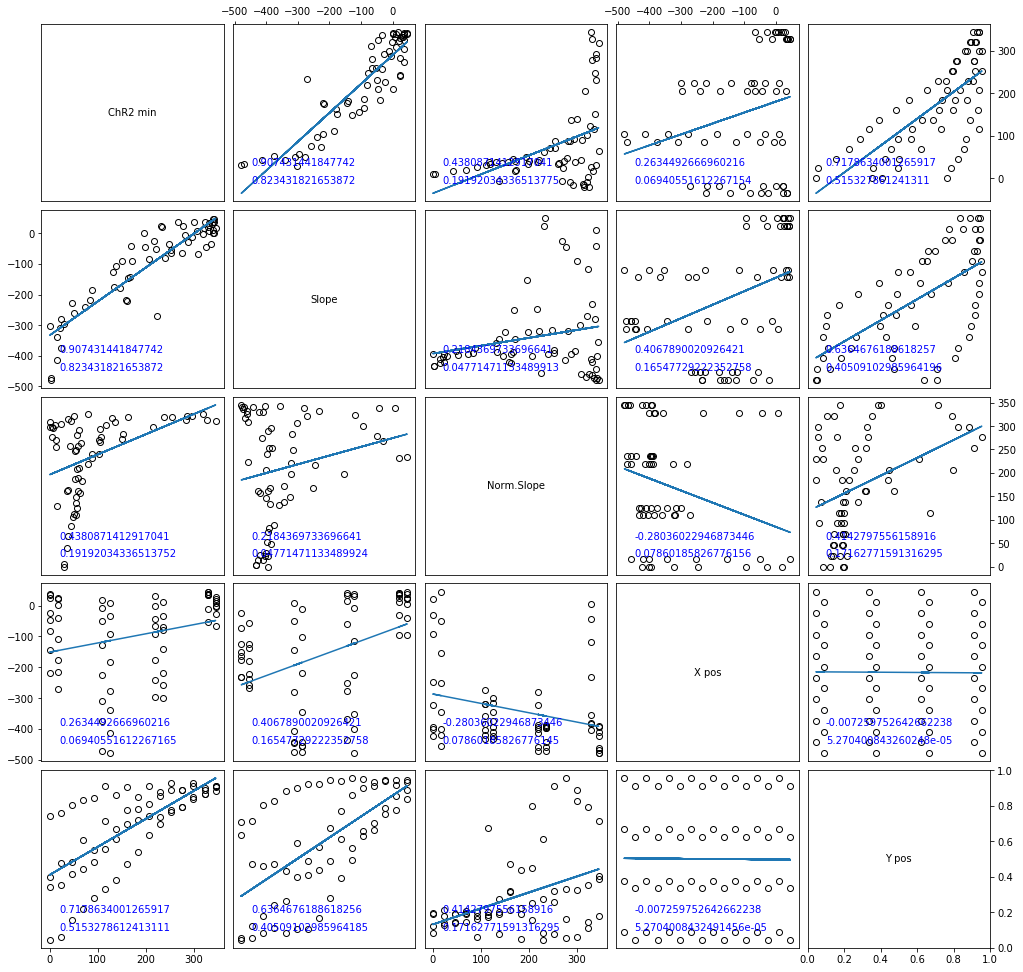

In [26]:
# Compute some correlations: (minimum of Chr, slope, xy positions, normalized slope)
# Plot correlations of everything
CorrObjectsList = np.asarray([np.asarray(MinChR2List), np.asarray(DerMin), np.asarray(normalized_slope),
                              np.asarray(xcoords), np.asarray(ycoords)])     
CorrObjectsNames = ['ChR2 min', 'Slope', 'Norm.Slope', 'X pos', 'Y pos']
fig = scatterplot_matrix(CorrObjectsList, CorrObjectsNames, linestyle='none', marker='o', color='black', mfc='none')
#plt.suptitle(Experiment + " Channel Idx "+str(signals.channel_id[ChxIdx]), y=0.92)
#plt.savefig(OutPutDir + Experiment + '_Correlations.pdf', transparent=True, bbox_inches='tight')
plt.show()

### break the session into chunks

In [62]:
n_chunks = 10
n_traces = traces_translated[0].shape[0]

In [63]:
# Get the averages of each electrode of each chunk
Average_chunks = [None] * number_of_channels
for j in range(number_of_channels):
    avg_chunk = [None] * n_chunks
    tr_tr_ch = np.array_split(traces_translated[j], n_chunks)
    for i, traces in enumerate(tr_tr_ch):
        avg = np.mean(traces, axis = 0)
        avg_chunk[i] = avg
    Average_chunks[j] = avg_chunk
    update_progress(j / number_of_channels)
update_progress(1)

Progress: [####################] 100.0%


Progress: [####################] 98.4%


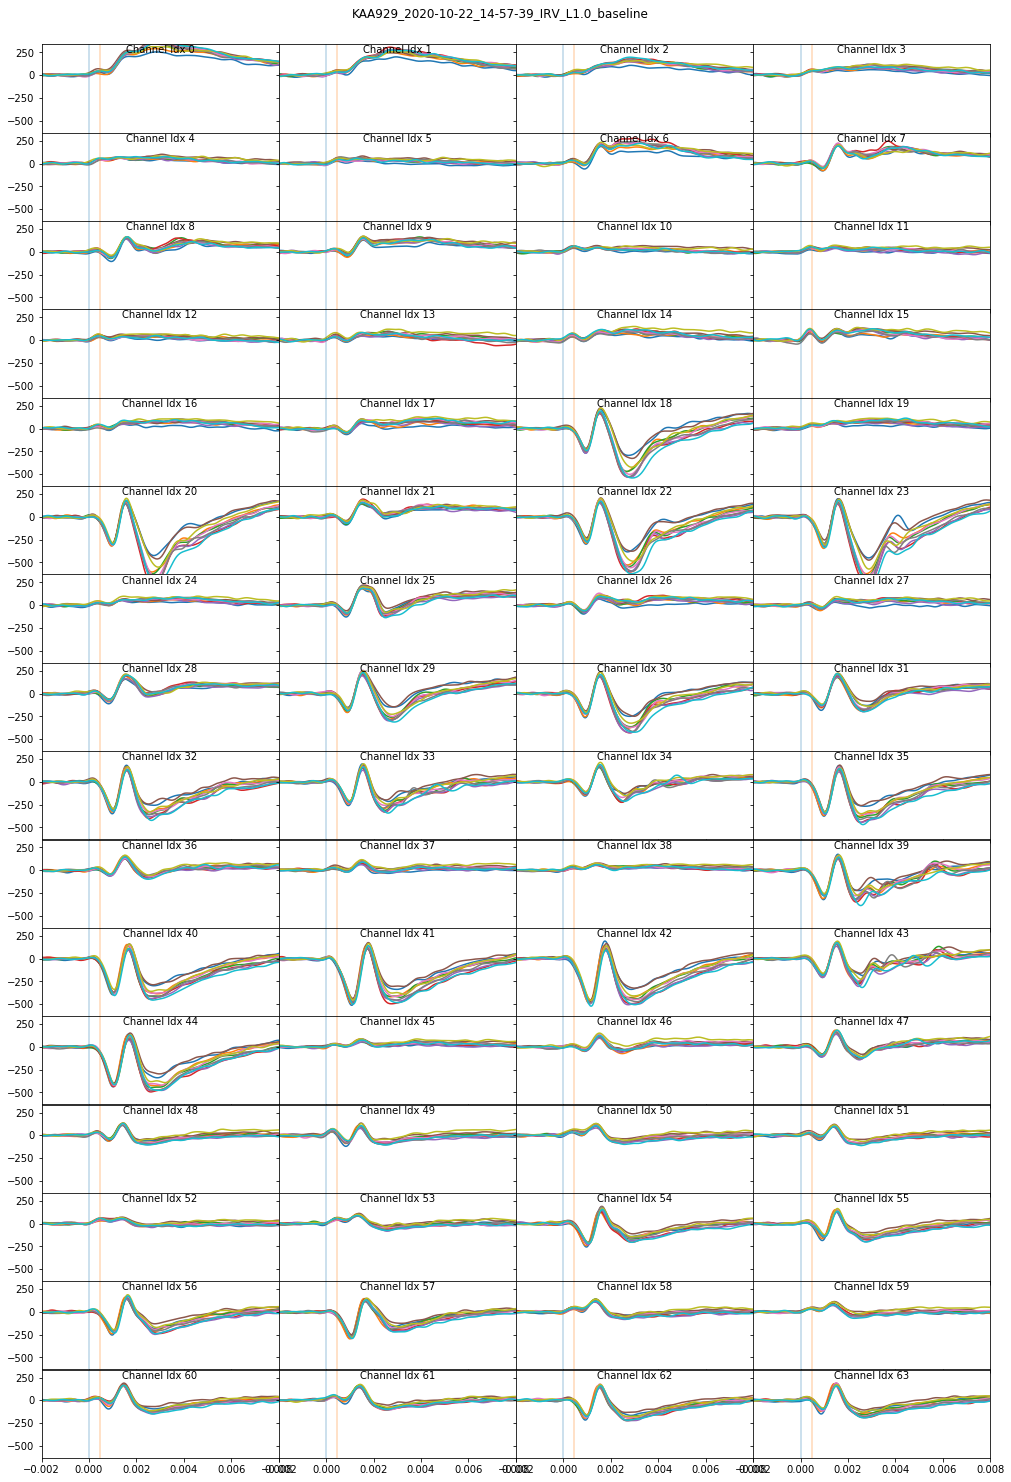

In [64]:
# Optional Check-point. Plot the signal of each channel
fig, axs = plt.subplots(math.ceil(number_of_channels/4), 4, figsize=(17, 26), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
plt.suptitle(Experiment, y=0.9)

for j in range(number_of_channels):
    for i in range(n_chunks):
        axs[j].plot(intervalTimes, Average_chunks[j][i])
    # zoom in the curve
    axs[j].set_xlim(-0.002, 0.008)
    axs[j].text(.5,.9,"Channel Idx "+str(signals.channel_id[j]), horizontalalignment='center', transform=axs[j].transAxes)
    update_progress(j / number_of_channels)

for j in range(number_of_channels):    
    axvlines(0, alpha = 0.3, ax = axs[j])
    axvlines(offset_delay, alpha = 0.3, ax = axs[j])
    axs[j].set_ylim(np.min(Average_traces),np.max(Average_traces))
#plt.savefig(outputDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

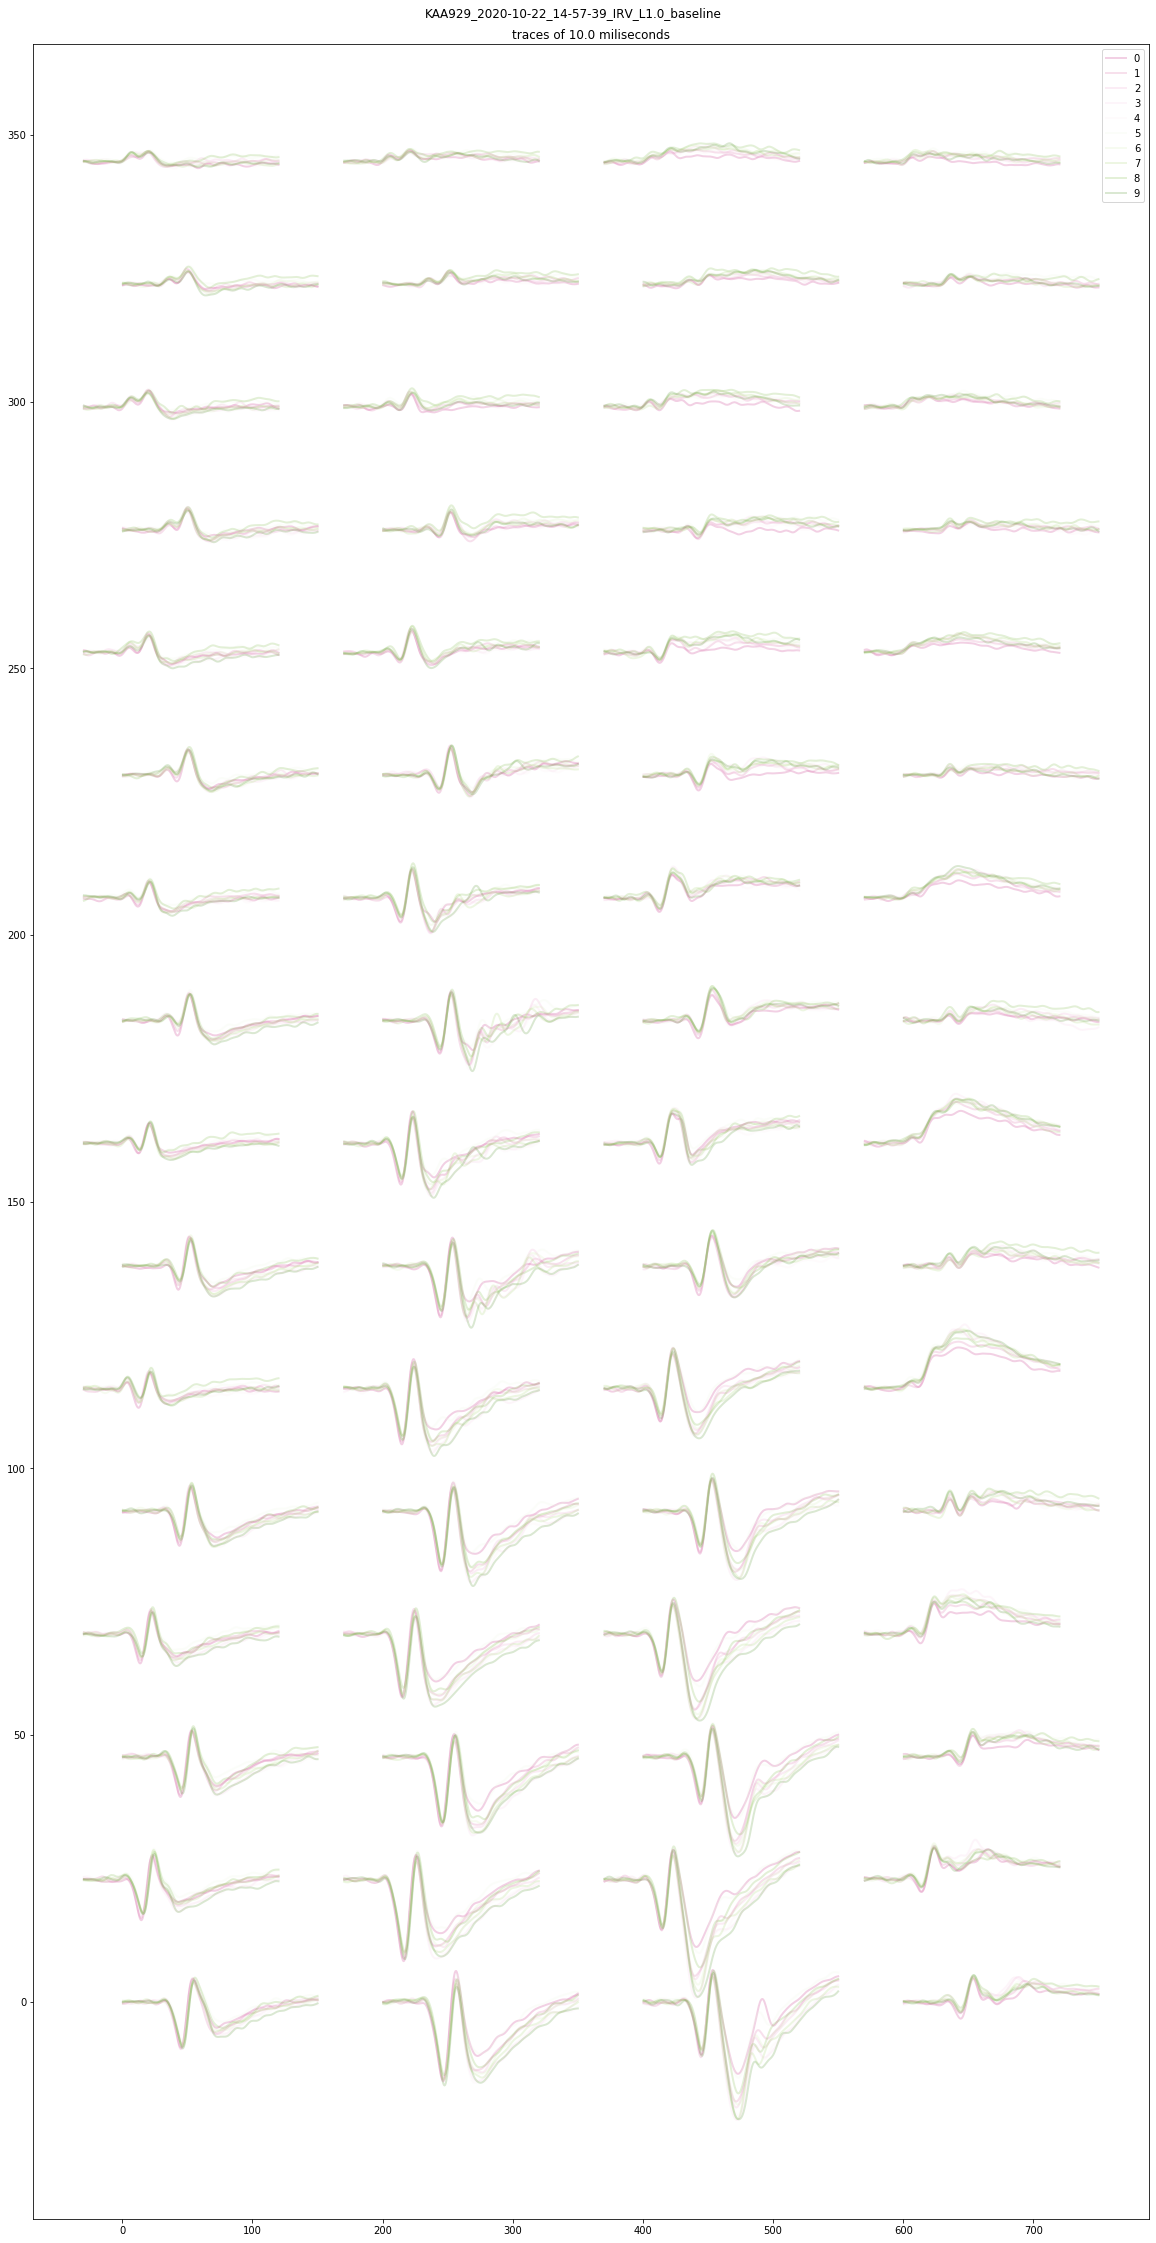

In [109]:
# plot the traces with the identified points
fig, axs = plt.subplots(1,1, figsize=(20, 40), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
#axs = axs.ravel()
x_scaler = 15000
y_scaler = 0.03
plt.title('traces of {} miliseconds'.format(1000 * (to_seconds - from_seconds)))
plt.suptitle(Experiment, y=0.893)

# plot the average trace
# define color palette
col_pal = sns.color_palette("PiYG", n_chunks)
# to save the legend
handles = []
labels = []
for i in range(n_chunks):
    traces = [j[i] for j in Average_chunks]
    axs, han, lab = pf.plot_traces_on_probe(ax=axs, intervalTimes=intervalTimes, traces=traces,
                                            idx=idx, xcoords=xcoords, ycoords=ycoords,
                                            x_scaler=x_scaler, y_scaler=y_scaler,
                                            normalized_slope=normalized_slope,
                                            color=col_pal[i], alpha=.2, linewidth=2,
                                            new_label=i)
    handles.append(han)
    labels.append(lab)
axs.legend(handles=handles, labels=labels)
plt.show()

In [97]:
handles

In [92]:
import seaborn as sns
sns.color_palette("viridis", 10)

[(0.283072, 0.130895, 0.449241),
 (0.262138, 0.242286, 0.520837),
 (0.220057, 0.343307, 0.549413),
 (0.177423, 0.437527, 0.557565),
 (0.143343, 0.522773, 0.556295),
 (0.119512, 0.607464, 0.540218),
 (0.166383, 0.690856, 0.496502),
 (0.319809, 0.770914, 0.411152),
 (0.525776, 0.833491, 0.288127),
 (0.762373, 0.876424, 0.137064)]

In [115]:
ycoords


array([115, 161, 207, 253, 299, 345,  69,  23,   0,  46, 322, 276, 230,
       184, 138,  92, 299, 253,  69, 345,  23, 207,  46,   0, 322, 161,
       230, 276, 184, 115,  92, 138, 115, 161, 207,  92, 253, 299, 345,
       138,  69,  23,   0, 184,  46, 322, 276, 230, 161, 115, 253, 207,
       345, 299,  23,  69,  46,   0, 276, 322, 184, 230,  92, 138])

## Batch run (needs updating)

Progress: [##################--] 90.0%


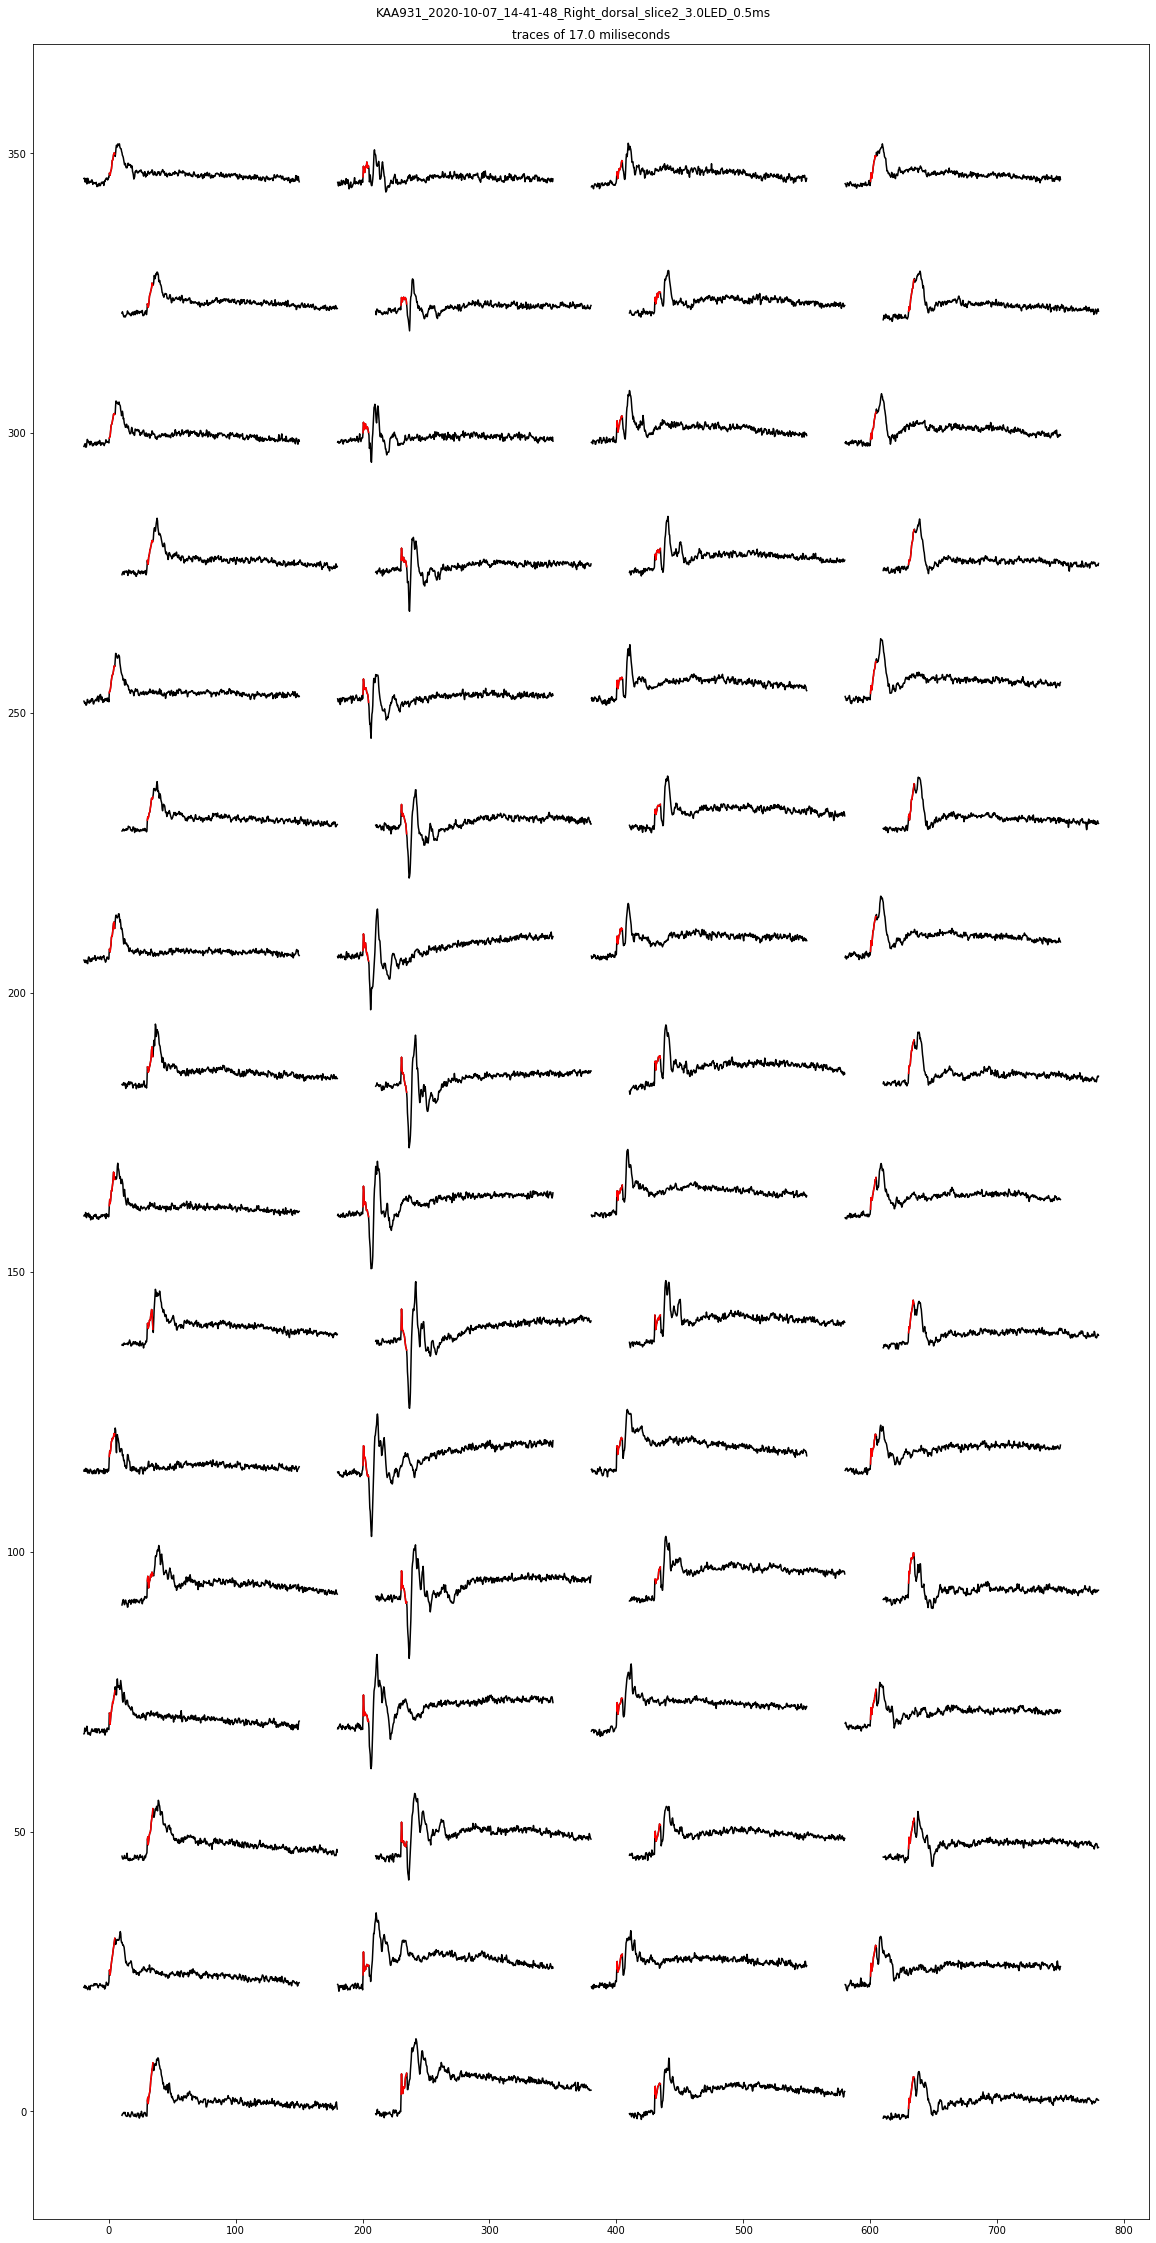

In [6]:
for i,e in enumerate(experiments_list):
    Experiment = e
    print(Experiment)
    number_of_channels = 64
    file = pyopenephys.File(GeneralDataDir + experiments_folder + '/' + Experiment)
    experiments = file.experiments
    experiment1 = experiments[0]
    recordings = experiment1.recordings
    recording = recordings[0]
    analog_signals = recording.analog_signals
    signals = analog_signals[0]
    events_data = recording.events
    events = events_data[0]



    ## ANALOG INPUT TO OE
    # Alternatively, get the analog channel get the analog channel
    analog_pulsepal = signals.signal[64]
    # find mid point and get idxs above
    #light_on_idx = np.where(analog_pulsepal > (max(analog_pulsepal) - min(analog_pulsepal))/2)[0]
    light_on_idx = np.where(analog_pulsepal > (np.median(analog_pulsepal)*10))[0]
    # indexes for onset, adding 1 because of np.diff
    onset_idxofidx = np.where(np.diff(light_on_idx)>1)[0] + 1
    offset_idxofidx = onset_idxofidx - 1
    # add the first and last occurrence
    onset_idxofidx = np.insert(onset_idxofidx, 0, 0)
    offset_idxofidx = np.append(offset_idxofidx, len(light_on_idx)-1)
    # get the times
    onset_times = signals.times[light_on_idx[onset_idxofidx]]
    offset_times = signals.times[light_on_idx[offset_idxofidx]]

    # classify the pulses and save them into a diccionary
    TTLs = {
            'soundPresentationTimes': onset_times,
            'soundOffsetTimes': offset_times
    }
    # get the difference (THIS ASSUMES IS ALWAYS THE SAME) For plotting purposes so far
    offset_delay = np.median(TTLs['soundOffsetTimes'] - TTLs['soundPresentationTimes']).item()



    # align data
    # interval for traces alignment. In seconds. Range of alignment
    intervalWindow = [-0.02,0.04]
    #firstpulses  = getFirstPulses(events.times, .5)
    traces_aligned = alignTrace(signals.signal, signals.times, TTLs['soundPresentationTimes'], intervalWindow, recording.sample_rate)
    intervalTimes = np.arange(intervalWindow[0], intervalWindow[1], 1/recording.sample_rate.base)
    # Override trace translation
    traces_translated = copy.deepcopy(traces_aligned)
    # Flip the traces
    traces_translated = [-x for x in traces_translated]   
    # Check-point. Plot the signal of each channel
    # Save the averages
    Average_traces = [None] * number_of_channels
    for j in range(number_of_channels):
        avg = np.mean(traces_translated[j], axis = 0)
        Average_traces[j] = avg
            
    # select times to plot
    from_seconds = -0.002
    to_seconds = 0.015
    iTvals = (intervalTimes > from_seconds) * (intervalTimes < to_seconds)
    idx = np.where(iTvals)
    light_idx = np.where((intervalTimes > 0) * (intervalTimes < offset_delay))


    fig, axs = plt.subplots(1,1, figsize=(20, 40), facecolor='w', edgecolor='k', sharex=True, sharey='row')
    fig.subplots_adjust(hspace = .001, wspace=.001)
    #axs = axs.ravel()
    x_scaler = 10000
    y_scaler = 0.055
    plt.title('traces of {} miliseconds'.format(1000 * (to_seconds - from_seconds)))
    plt.suptitle(Experiment, y=0.893)
    for j in range(len(xcoords)):
        axs.plot(xcoords[j] + intervalTimes[idx] * x_scaler,
                 ycoords[j] + Average_traces[j][idx] * y_scaler,
                 color = 'k')
        # plot when the light is on
        axs.plot(xcoords[j] + intervalTimes[light_idx] * x_scaler,
                 ycoords[j] + Average_traces[j][light_idx] * y_scaler,
                 color = 'r')

    plt.savefig(outputDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
    update_progress(i/len(experiments_list))
    plt.show()
    

***
### Dumpster

In [133]:
#del quit
#del local_vars
#del get_ipython
del fig
#del exit
del axs
del Out
del traces_aligned
del traces_translated

In [26]:
# save the workspace [currently saves EVERYTHING, which is very innefficient]
# I have tried to make it nicer by removing elements that are unnecessary, but I haven't find a nice way to
# find out which big unnecessary elements are these
dill.dump_session(outputDir + Experiment + '_workspace.db')

In [6]:
import dill
dill.load_session(outputDir + Experiment + '_workspace.db')

KeyError: 'ClassType'

In [28]:
import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType


def getsize(obj):
    """sum size of object & members."""
    #if isinstance(obj, BLACKLIST):
    #    raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
   
    if not isinstance(obj, BLACKLIST):
        seen_ids = set()
        size = 0
        objects = [obj]
        while objects:
            need_referents = []
            for obj in objects:
                if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                    seen_ids.add(id(obj))
                    size += sys.getsizeof(obj)
                    need_referents.append(obj)
            objects = get_referents(*need_referents)
        return size

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

sizes = {}
for name in dir():
    if '(' not in name:
        #print(name)
        if not name.startswith('_'):
            size = getsize(vars()[name])
            if size is not None:
                sizes[name] = size
                #print('{}: {}'.format(name, size))

{k: sizeof_fmt(v) for k, v in sorted(sizes.items(), key=lambda item: -item[1])}

{'quit': '2.4 MiB',
 'get_ipython': '2.4 MiB',
 'fig': '2.4 MiB',
 'exit': '2.4 MiB',
 'axs': '2.4 MiB',
 'experiment1': '494.1 KiB',
 'experiments': '494.1 KiB',
 'file': '494.1 KiB',
 'recording': '494.1 KiB',
 'recordings': '494.1 KiB',
 'In': '19.8 KiB',
 'Out': '11.8 KiB',
 'traces_aligned': '8.6 KiB',
 'traces_translated': '8.6 KiB',
 'Average_traces': '6.7 KiB',
 'ElectrodeLFPData': '6.7 KiB',
 'filtered_averages': '6.7 KiB',
 'sizes': '6.2 KiB',
 'TTLs': '5.1 KiB',
 'probeposfile': '4.6 KiB',
 'events_data': '4.1 KiB',
 'events': '4.0 KiB',
 'analog_signals': '3.9 KiB',
 'offset_times': '3.8 KiB',
 'onset_times': '3.8 KiB',
 'signals': '3.8 KiB',
 'DerMin': '2.7 KiB',
 'DerMinIdx': '2.7 KiB',
 'DerMinTime': '2.7 KiB',
 'MaxChR2List': '2.7 KiB',
 'MaxChR2ListTime': '2.7 KiB',
 'MinChR2List': '2.7 KiB',
 'MinChR2ListTime': '2.7 KiB',
 'x_s': '2.7 KiB',
 'y_s': '2.7 KiB',
 'experiments_list': '1.4 KiB',
 'MaxChR2ListIdx': '1.1 KiB',
 'MinChR2ListIdx': '1.0 KiB',
 'sel_idx': '712.0

In [ ]:
'''
# fix the timestamp.npy file. ONLY IF READING THE FILE FAILS
# this will probably make the digital ttls unusable
nchan = 72
subdir = '/experiment1/recording1/continuous/Rhythm_FPGA-101.0/'
tsfile = GeneralDataDir + Experiment + subdir + 'timestamps.npy'
#ts = np.load(tsfile)
ts.shape

contfile = GeneralDataDir + Experiment + subdir + 'continuous.dat'
contdata = np.fromfile(contfile, dtype=np.int16)
ts = np.array(range(int(contdata.shape[0]/nchan))).astype(np.int16)
np.save(tsfile, ts)
'''

***
### run one of the two cells below

In [ ]:
## DIGITAL INPUT TO OE
# get TTLs
rawTTLs = getTTLs(recording.events[0])[0]
# classify the pulses and save them into a diccionary
soundPresentationTimes = getFirstPulses(rawTTLs, 2) #Detect first events (separated by at least 2 seconds)
TTLs = {
        'soundPresentationTimes': soundPresentationTimes,
        'soundOffsetTimes': np.setdiff1d(rawTTLs, soundPresentationTimes), #get sound offset
}
# get the difference (THIS ASSUMES IS ALWAYS THE SAME) For plotting purposes so far
offset_delay = np.median(TTLs['soundOffsetTimes'] - TTLs['soundPresentationTimes']).item()

****
##### process data

In [ ]:
# FILTER TEST
ChID = 29
# 2. filter the data
Filter_Low_Value = 100
Filter_High_Value = 2000
filteredData = copy.deepcopy(signals.signal)
#b,a = butter_lowpass(600, recording.sample_rate)
b,a = butter_lowpass(Filter_High_Value, recording.sample_rate)
fd = filtfilt(b, a, signals.signal[ChID])

# Plot some examples (first, 5th, 10th and 15th pulse)
fig, axs = plt.subplots(6, 1, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.1)
axs = axs.ravel()

# every x pulses
every_x = 1

for i in range(6):
    pulseTime = TTLs['soundPresentationTimes'][i*every_x].item()
    pulseFrame = int(pulseTime * recording.sample_rate.item())
    pFS = int(pulseFrame - 0.01 * recording.sample_rate.item())
    pFF = int(pulseFrame + 0.01 * recording.sample_rate.item())
    #extract frames around the pulse
    axs[i].plot(signals.times[pFS:pFF],signals.signal[ChID][pFS:pFF])
    axs[i].plot(signals.times[pFS:pFF],fd[pFS:pFF])
    axvlines(pulseTime, ax=axs[i])
    axvlines(TTLs['soundOffsetTimes'][i*every_x].item(), ax=axs[i])

plt.show()


In [ ]:
# 2. filter the data
Filter_Low_Value = 100
Filter_High_Value = 800
filteredData = copy.deepcopy(signals.signal)
#b,a = butter_lowpass(600, recording.sample_rate)
b,a = butter_bandpass(Filter_Low_Value, Filter_High_Value, recording.sample_rate)
for electrodeID in range(64):
    filteredData[electrodeID] = filtfilt(b, a, signals.signal[electrodeID])
    update_progress(electrodeID / 64)
update_progress(1)

In [ ]:
# Check point
# Check how the filtered data looks like
# Select a channel
ChId = 16
# Plot some examples (first, 5th, 10th and 15th pulse)
fig, axs = plt.subplots(2, 2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.1)
axs = axs.ravel()
plt.suptitle(Experiment + '_Filter channel ' + str(ChId), y=0.9)

for i in range(4):
    pulseTime = TTLs['soundPresentationTimes'][i*5].item()
    pulseFrame = int(pulseTime * recording.sample_rate.item())
    pFS = int(pulseFrame - 0.05 * recording.sample_rate.item())
    pFF = int(pulseFrame + 0.05 * recording.sample_rate.item())
    #extract frames around the pulse
    axs[i].plot(signals.times[pFS:pFF],signals.signal[ChId][pFS:pFF])
    axs[i].plot(signals.times[pFS:pFF],filteredData[ChId][pFS:pFF])
    axvlines(pulseTime, ax = axs[i])
    axvlines(TTLs['soundOffsetTimes'][i*5].item(), ax=axs[i])
#plt.savefig(OutPutDir + Experiment + '_FilteredSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# override filtering:
filteredData = copy.deepcopy(signals.signal)

In [ ]:
# Check point
# Check how the filtered data looks like
# Select a channel
ChId = 29
# Plot some examples (first, 10th, 20th and 30th pulse)
fig, axs = plt.subplots(1, 1, figsize=(17, 5), facecolor='w', edgecolor='k')
plt.suptitle(Experiment + '_Filter channel ' + str(ChId), y=0.9)
axs.plot(signals.times,signals.signal[ChId])
plt.show()

In [ ]:
# 3. align data
# interval for traces alignment. In seconds. Range of alignment
intervalWindow = [-0.02,0.04]
#firstpulses  = getFirstPulses(events.times, .5)
traces_aligned = alignTrace(filteredData, signals.times, TTLs['soundPresentationTimes'], intervalWindow, recording.sample_rate)
intervalTimes = np.arange(intervalWindow[0], intervalWindow[1], 1/recording.sample_rate.base)
print(Experiment + ' analyzed...')

In [ ]:
# 4. translate data
# seconds to calculate the mean before 0 and translate each trace
sToSubstract = 0.005
traces_translated = copy.deepcopy(traces_aligned)
for electrodeID in range(len(traces_translated)):
    for traceID in range(len(traces_translated[electrodeID])):        
        traces_translated[electrodeID][traceID] = translateTrace(traces_aligned[electrodeID][traceID], intervalTimes, recording.sample_rate, sToSubstract)   
    update_progress(electrodeID / len(traces_translated))
update_progress(1)

In [ ]:
# Override trace translation
traces_translated = copy.deepcopy(traces_aligned)

In [ ]:
# Check-point. Plot the signal of each channel
fig, axs = plt.subplots(math.ceil(number_of_channels/4), 4, figsize=(17, 26), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
plt.suptitle(Experiment, y=0.9)

# Save the averages
Average_traces = [None] * number_of_channels

for j in range(number_of_channels):
    for i in range(traces_translated[j].shape[0]):
        axs[j].plot(intervalTimes, traces_translated[j][i,], color = 'grey', linewidth = 0.1, alpha = 0.6)
    avg = np.mean(traces_translated[j], axis = 0)
    Average_traces[j] = avg
    axs[j].plot(intervalTimes, avg)
    # zoom in the curve
    axs[j].set_xlim(-0.002, 0.02)
    axs[j].text(.5,.9,"Channel Idx "+str(signals.channel_id[j]), horizontalalignment='center', transform=axs[j].transAxes)
    update_progress(j / number_of_channels)

for j in range(number_of_channels):    
    axvlines(0, alpha = 0.3, ax = axs[j])
    axvlines(offset_delay, alpha = 0.3, ax = axs[j])
    axs[j].set_ylim(np.min(Average_traces),np.max(Average_traces))
#plt.savefig(OutPutDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [20]:
# check how they map to the electrodes in the 4-shank probe
# micron coordinates
xcoords = np.array([600, 600, 600, 600, 600, 600, 600, 600,
    630, 630, 630, 630, 630, 630, 630, 630,
    400, 400, 400, 400, 400, 400, 430, 430,
    430, 400, 430, 430, 430, 400, 430, 430,
    200, 200, 200, 230, 200, 200, 200, 230,
    200, 200, 230, 230, 230, 230, 230, 230,
    0, 0, 0, 0, 0, 0, 0, 0,
    30, 30, 30, 30, 30, 30, 30, 30])

# position in the shank from low to bottom
ycoords = np.array([5, 7, 9, 11, 13, 15, 3, 1,
    0, 2, 14, 12, 10, 8, 6, 4,
    13, 11, 3, 15, 1, 9, 2, 0,
    14, 7, 10, 12, 8, 5, 4, 6,
    5, 7, 9, 4, 11, 13, 15, 6,
    3, 1, 0, 8, 2, 14, 12, 10,
    7, 5, 11, 9, 15, 13, 1, 3,
    2, 0, 12, 14, 8, 10, 4, 6])
# get the actual positions (how far up they are from the tip)
ycoords = ycoords * 23;

kcoords = np.array([1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1,
    2, 2, 2, 2, 2, 2, 2, 2,
    2, 2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3, 3, 3, 3, 3,
    3, 3, 3, 3, 3, 3, 3, 3,
    4, 4, 4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4, 4, 4, 4]) #% grouping of channels (i.e. tetrode groups)

In [25]:
f = open(outputDir+'4shankNeuroNexusPositions.pkl', 'wb')
pickle.dump(xcoords, f)
pickle.dump(ycoords, f)
pickle.dump(kcoords, f)
f.close()

In [112]:
# check how they map to the electrodes in the 2-shank probe
# micron coordinates
xcoords = np.array([365, 365, 365, 380, 365, 380, 365, 380,
                    365, 380, 365, 380, 365, 380, 380, 380,
                    350, 365, 350, 365, 365, 350, 365, 350,
                    350, 350, 350, 365, 365, 350, 365, 365,
                    15, 15, 15, 30, 30, 15, 30, 30,
                    15, 30, 15, 30, 30, 15, 30, 15,
                    0, 0, 15, 0, 15, 0, 15, 0,
                    15, 0, 15, 0, 15, 0, 15, 15])

# position in the shank from low to bottom
ycoords = np.array([940, 810, 680, 925, 550, 795, 420, 665,
                    290, 535, 160, 405, 30, 275, 15, 145,
                    405, 0, 535, 130, 260, 275, 390, 665,
                    795, 15, 925, 520, 650, 145, 910, 780,
                    940, 810, 680, 145, 925, 550, 795, 15,
                    420, 665, 290, 275, 535, 160, 405, 30,
                    15, 145, 0, 275, 130, 405, 260, 535,
                    390, 665, 520, 795, 650, 925, 910, 780])

kcoords = np.array([2, 2, 2, 2, 2, 2, 2, 2,
                    2, 2, 2, 2, 2, 2, 2, 2,
                    2, 2, 2, 2, 2, 2, 2, 2,
                    2, 2, 2, 2, 2, 2, 2, 2,
                    1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1]) #% grouping of channels (i.e. tetrode groups)

In [126]:
f = open(outputDir + '2shankNeuroNexusPositions.pkl', 'wb')
pickle.dump(xcoords, f)
pickle.dump(ycoords, f)
pickle.dump(kcoords, f)

f.close()

In [125]:
os.getcwd()

'/mnt/c/Users/herny/Documents/GitHub/OpenEphys_Analysis'

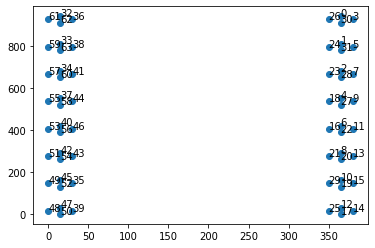

In [113]:
plt.plot(xcoords, ycoords, 'o')
for i in range(64):
    plt.text(xcoords[i], ycoords[i], str(i))

In [ ]:
# This is like looking at the probe from the front

# select times to plot
from_seconds = -0.002
to_seconds = 0.02
iTvals = (intervalTimes > from_seconds) * (intervalTimes < to_seconds)
idx = np.where(iTvals)

fig, axs = plt.subplots(1,1, figsize=(20, 40), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
#axs = axs.ravel()
x_scaler = 8000
y_scaler = 0.5
plt.suptitle(Experiment, y=0.9)
for j in range(len(xcoords)):
    axs.plot(xcoords[j] + intervalTimes[idx] * x_scaler, ycoords[j] + Average_traces[j][idx] * y_scaler)
    update_progress(j / len(xcoords))
    
#for j in range(len(traces_translated)):    
#    axvlines(0, alpha = 0.3, ax = axs[j])
#    axvlines(offset_delay, alpha = 0.3, ax = axs[j])
#plt.savefig(OutPutDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# plot the mean over each probe of the lower channels TODO
#fig, axs = plt.subplots(1,4, figsize=(20, 5), facecolor='w', edgecolor='k', sharex=True, sharey='row')
#fig.subplots_adjust(hspace = .001, wspace=.001)
plt.plot(intervalTimes[idx],np.mean(Average_traces, axis=0)[idx])